In [ ]:
!pip install pulp networkx matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 96.0 MB/s eta 0:00:00


In [ ]:
# 在Colab单元格中运行这些命令
# !apt-get update
!apt-get install -y graphviz libgraphviz-dev pkg-config
!pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
Suggested packages:
  gvfs
The following packages will be REMOVED:
  pkgconf r-base-dev
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk librsvg2-common libxdot4 pkg-config
0 upgraded, 10 newly installed, 2 to remove and 38 not upgraded.
Need to get 2,482 kB of archives.
After this operation, 7,671 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 pkg-config a

In [ ]:
# !pip install --upgrade pip setuptools

In [ ]:
# !pip install git+https://github.com/Pabloo22/job_shop_lib.git

In [ ]:
!pip install job-shop-lib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.1/293.1 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.0/25.0 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 7.4 MB/s eta 0:00:00
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0


In [ ]:
!pip install joblib

Loaded ft06, total ops: 36 horizon est: 197
Jobs: 6
Machines: 6


== Decomposition: Fix-and-Optimize (local machine-wise) ==

== LP relaxation + rounding ==
LP status: Optimal LP relax objective: 47.0
Rounded schedule makespan: 68
 No improvement in iteration 0
Decomposition final makespan: 68


/tmp/ipython-input-2231992945.py:372: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


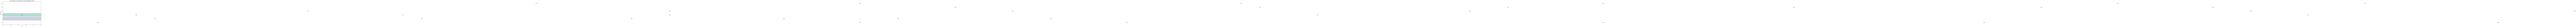

In [ ]:
# jssp_ft06_methods.py
# Requires: pulp, job-shop-lib, networkx, matplotlib (optional)
# pip install pulp job-shop-lib networkx matplotlib


import itertools
import math
from job_shop_lib.benchmarking import load_benchmark_instance
from job_shop_lib import Operation
import pulp
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


# -------------------------
# Helper utilities
# -------------------------
def load_ft06():
  #  inst = load_benchmark_instance("la40")
   inst = load_benchmark_instance("ft06")
   # inst.jobs is list of job ops; each job: list of Operation objects
   ops = []
   for j, job in enumerate(inst.jobs):
       for k, operation in enumerate(job):
           # Operation对象有machine_id和duration属性
           ops.append({
               'id': (j, k),
               'job': j,
               'idx': k,
               'mach': operation.machine_id,
               'proc': operation.duration
           })
   return inst, ops


def horizon_estimate(ops):
   return sum(o['proc'] for o in ops)


def build_disjunctive_milp(ops, horizon=None, enforce_binary=True):
   """Return (model, S_vars, X_vars, Cmax) using PuLP.
   If enforce_binary=False, x vars are continuous in [0,1] (LP relaxation).
   """
   model = pulp.LpProblem("JSSP_DISJUNCTIVE", pulp.LpMinimize)
   S = {}  # start time variables
   for o in ops:
       S[o['id']] = pulp.LpVariable(f"S_{o['id'][0]}_{o['id'][1]}", lowBound=0, cat='Continuous')
   Cmax = pulp.LpVariable("Cmax", lowBound=0, cat='Continuous')
   model += Cmax


   # precedence within job
   jobs = {}
   for o in ops:
       jobs.setdefault(o['job'], []).append(o)
   for j, job_ops in jobs.items():
       # assume ops already in order by idx
       job_ops_sorted = sorted(job_ops, key=lambda x: x['idx'])
       for a, b in zip(job_ops_sorted[:-1], job_ops_sorted[1:]):
           model += S[b['id']] >= S[a['id']] + a['proc']


   # disjunctive ordering variables for pairs on same machine
   if horizon is None:
       horizon = horizon_estimate(ops)
   M = horizon  # reasonable big-M


   X = {}
   for o1, o2 in itertools.combinations(ops, 2):
       if o1['mach'] != o2['mach']:
           continue
       a = o1['id']; b = o2['id']
       if enforce_binary:
           X[(a,b)] = pulp.LpVariable(f"x_{a}_{b}", cat='Binary')
       else:
           X[(a,b)] = pulp.LpVariable(f"x_{a}_{b}", lowBound=0, upBound=1, cat='Continuous')
       # a before b if x=1
       model += S[a] + o1['proc'] <= S[b] + M*(1 - X[(a,b)])
       model += S[b] + o2['proc'] <= S[a] + M*(X[(a,b)])
   # makespan constraints
   for o in ops:
       model += Cmax >= S[o['id']] + o['proc']
   return model, S, X, Cmax


def solve_pulp_model(model, time_limit=None, msg=False):
   solver = pulp.PULP_CBC_CMD(msg=msg, timeLimit=time_limit) if time_limit else pulp.PULP_CBC_CMD(msg=msg)
   model.solve(solver)
   return pulp.LpStatus[model.status], pulp.value(model.objective)


def extract_schedule_from_S(S_vars):
   Svals = {k: pulp.value(v) for k, v in S_vars.items()}
   return Svals


def makespan_from_S(Svals, ops):
   # ensure all ops present
   mm = 0
   for o in ops:
       s = Svals.get(o['id'], None)
       if s is None:
           return float('inf')
       mm = max(mm, s + o['proc'])
   return mm


def greedy_schedule_from_orderings(ops, orderings):
   """
   Build schedule by list-scheduling (respecting job order and machine order).
   orderings: dict mapping pair (a,b) -> 1 means a before b, 0 means b before a.
   We'll greedily schedule operations by earliest feasible start (respect both precedence and machine previously scheduled ops).
   Returns start times dict.
   """
   # initialize remaining ops per job, and ready set
   remaining = {o['id']: dict(o) for o in ops}
   # track job precedence: next operation index per job to schedule
   next_op_idx = {o['job']: 0 for o in ops}
   total_ops = len(ops)
   scheduled = {}
   # machine last completion times
   machine_time = {}
   # while unscheduled ops remain
   while len(scheduled) < total_ops:
       # find all ops whose predecessors (job sequence) are done
       ready = []
       for o in ops:
           if o['id'] in scheduled:
               continue
           if o['idx'] == 0:
               ready.append(o)
           else:
               # predecessor id
               pred = (o['job'], o['idx'] - 1)
               if pred in scheduled:
                   ready.append(o)
       # for ready ops, compute earliest start considering machine last completion and ordering constraints vs other ready ops?
       # We'll choose the operation with earliest possible start (tie break by job id)
       best_o = None; best_start = None
       for o in ready:
           # earliest by job precedence:
           if o['idx'] > 0:
               pred = (o['job'], o['idx'] - 1)
               pred_proc = next(p['proc'] for p in ops if p['id']==pred)
               est = scheduled[pred] + pred_proc
           else:
               est = 0
           mach = o['mach']
           est = max(est, machine_time.get(mach, 0))
           # also respect ordering constraints w.r.t. already scheduled operations on same machine
           for qid, sstart in scheduled.items():
               q = next(filter(lambda z: z['id']==qid, ops))
               if q['mach'] != o['mach']:
                   continue
               # if ordering says q before o (i.e., orderings.get((qid, o['id']))==1) then ensure est large enough
               if orderings.get((qid, o['id']), None) == 1:
                   est = max(est, sstart + q['proc'])
           # choose op with smallest est
           if best_start is None or est < best_start - 1e-9 or (abs(est - best_start) < 1e-9 and o['job'] < best_o['job']):
               best_o = o
               best_start = est
       if best_o is None:
           raise RuntimeError("No ready op found (cyclic?).")
       scheduled[best_o['id']] = best_start
       machine_time[best_o['mach']] = best_start + best_o['proc']
   return scheduled


# -------------------------
# 1) MILP (Disjunctive Big-M)
# -------------------------
def run_milp_disjunctive(ops, horizon=None):
   print("\n== MILP Disjunctive (Big-M) ==")
   model, S, X, Cmax = build_disjunctive_milp(ops, horizon, enforce_binary=True)
   status, obj = solve_pulp_model(model, msg=False)
   print("Status:", status, "Makespan:", obj)
   Svals = extract_schedule_from_S(S)
   return status, obj, Svals, X


# -------------------------
# 2) Cutting-plane iterative (LP relax -> separate overlaps)
# -------------------------
def run_cutting_plane_iter_improved(ops, horizon=None, max_iters=20):
   print("\n== Improved Cutting-plane iterative ==")
   model, S, X, Cmax = build_disjunctive_milp(ops, horizon, enforce_binary=False)
   added_cuts = 0

   best_lp_obj = float('inf')
   best_Svals = None

   for it in range(max_iters):
       status, obj = solve_pulp_model(model, msg=False)
       Svals = {k: pulp.value(v) for k, v in S.items()}

       # 记录最好的LP解
       if obj < best_lp_obj:
           best_lp_obj = obj
           best_Svals = Svals.copy()

       print(f" Iter {it}: LP objective (Cmax) = {obj:.3f}")

       # 检测重叠的操作对
       viols = []
       for o1, o2 in itertools.combinations(ops, 2):
           if o1['mach'] != o2['mach']:
               continue
           a, b = o1['id'], o2['id']
           sa = Svals.get(a); sb = Svals.get(b)
           if sa is None or sb is None:
               continue

           # 检查是否真正重叠（考虑容差）
           overlap = (sa < sb + o2['proc'] - 1e-6) and (sb < sa + o1['proc'] - 1e-6)
           if overlap:
               xv = pulp.value(X[(a,b)]) if (a,b) in X else 0.5

               # 更保守的割平面策略
               if xv > 0.7:  # 更确信a在b之前
                   model += S[a] + o1['proc'] <= S[b]
                   viols.append((a,b,"a<b (confident)"))
               elif xv < 0.3:  # 更确信b在a之前
                   model += S[b] + o2['proc'] <= S[a]
                   viols.append((a,b,"b<a (confident)"))
               # 否则不添加割平面，保持灵活性

       if not viols:
           print(" No overlapping pairs detected. Stop.")
           break

       added_cuts += len(viols)
       print(f"  Added {len(viols)} cuts, total: {added_cuts}")

       # 如果目标函数恶化太多，回退到最佳解
       if obj > best_lp_obj + 10:  # 如果比最佳解差10以上
           print(" Objective deteriorated, reverting to best LP solution")
           # 基于最佳LP解构建割平面
           break

   # 使用最佳LP解来引导MILP
   print("Building MILP with guidance from best LP solution...")
   model2, S2, X2, C2 = build_disjunctive_milp(ops, horizon, enforce_binary=True)

   # 基于最佳LP解添加有信心的优先约束
   if best_Svals:
       confident_cuts = 0
       for o1, o2 in itertools.combinations(ops, 2):
           if o1['mach'] != o2['mach']:
               continue
           a, b = o1['id'], o2['id']
           sa = best_Svals.get(a); sb = best_Svals.get(b)
           if sa is None or sb is None:
               continue

           # 只有在时间上有明显先后关系时才添加约束
           time_gap = abs(sa - sb)
           if time_gap > max(o1['proc'], o2['proc']) / 2:
               if sa + o1['proc'] <= sb + 1e-6:
                   model2 += S2[a] + o1['proc'] <= S2[b]
                   confident_cuts += 1
               elif sb + o2['proc'] <= sa + 1e-6:
                   model2 += S2[b] + o2['proc'] <= S2[a]
                   confident_cuts += 1
       print(f"Added {confident_cuts} confident precedence constraints")

   st2, obj2 = solve_pulp_model(model2, msg=False, time_limit=60)
   Svals2 = {k: pulp.value(v) for k,v in S2.items() if pulp.value(v) is not None}

   print("Final MILP status:", st2, "makespan:", obj2)
   return st2, obj2, Svals2


# -------------------------
# 3) LP relaxation + rounding
# -------------------------
def run_lp_relaxation_and_rounding(ops, horizon=None):
   print("\n== LP relaxation + rounding ==")
   model, S, X, Cmax = build_disjunctive_milp(ops, horizon, enforce_binary=False)
   st, obj = solve_pulp_model(model, msg=False)
   print("LP status:", st, "LP relax objective:", obj)
   # round x to 0/1 using 0.5 threshold
   rounded_order = {}
   for (a,b), var in X.items():
       val = pulp.value(var)
       if val is None: continue
       rounded = 1 if val >= 0.5 else 0
       rounded_order[(a,b)] = rounded
       # also set the opposite mapping for convenience
       rounded_order[(b,a)] = 0 if rounded==1 else 1
   # build schedule greedily from rounded orderings
   sched = greedy_schedule_from_orderings(ops, rounded_order)
   makespan = makespan_from_S(sched, ops)
   print("Rounded schedule makespan:", makespan)
   return sched, makespan, rounded_order


# -------------------------
# 4) Decomposition: Fix-and-optimize local decomposition (heuristic)
# -------------------------
def run_decomposition_fix_optimize(ops, horizon=None, iters=10):
   print("\n== Decomposition: Fix-and-Optimize (local machine-wise) ==")
   # initialize ordering via LP rounding
   sched, mk, rounded = run_lp_relaxation_and_rounding(ops, horizon)
   best_sched = dict(sched); best_mk = mk
   machines = sorted(set(o['mach'] for o in ops))
   for it in range(iters):
       improved = False
       for m in machines:
           # get ops on machine m in current order (by scheduled start)
           ops_on_m = sorted([o for o in ops if o['mach']==m], key=lambda z: best_sched[z['id']])
           # try local swaps among ops_on_m and evaluate schedule
           for i in range(len(ops_on_m)-1):
               # create a candidate ordering where we swap neighbors i and i+1
               candidate_orderings = dict(rounded)  # copy
               a = ops_on_m[i]['id']; b = ops_on_m[i+1]['id']
               # flip ordering for pair (a,b)
               candidate_orderings[(a,b)] = 0
               candidate_orderings[(b,a)] = 1
               # create schedule from these orderings (keeping other machines' orderings same)
               try:
                   cand_sched = greedy_schedule_from_orderings(ops, candidate_orderings)
               except Exception:
                   continue
               cand_mk = makespan_from_S(cand_sched, ops)
               if cand_mk < best_mk - 1e-9:
                   print(f" Iter {it} machine {m}: improved {best_mk} -> {cand_mk} by swapping {a} & {b}")
                   best_mk = cand_mk
                   best_sched = cand_sched
                   rounded = candidate_orderings
                   improved = True
                   break
           if improved:
               break
       if not improved:
           print(" No improvement in iteration", it)
           break
   print("Decomposition final makespan:", best_mk)
   return best_sched, best_mk


# -------------------------
# Simple Gantt chart (matplotlib)
# -------------------------
def plot_gantt(schedule, ops, title="Gantt"):
   # schedule: dict id -> start
   fig, ax = plt.subplots(figsize=(10, 6))
   machines = sorted(set(o['mach'] for o in ops))
   mach_to_y = {m: i for i,m in enumerate(machines)}

   # 为不同工件使用不同颜色
   colors = plt.cm.Set3(np.linspace(0, 1, len(set(o['job'] for o in ops))))

   for o in ops:
       s = schedule[o['id']]
       color = colors[o['job'] % len(colors)]
       rect = plt.Rectangle((s, mach_to_y[o['mach']]-0.4), o['proc'], 0.8,
                          edgecolor='k', facecolor=color, alpha=0.7)
       ax.add_patch(rect)
       ax.text(s + o['proc']/2, mach_to_y[o['mach']],
              f"J{o['job']}O{o['idx']}", ha='center', va='center',
              color='black', fontsize=8, weight='bold')

   ax.set_yticks([mach_to_y[m] for m in machines])
   ax.set_yticklabels([f"M{m}" for m in machines])
   ax.set_xlabel("Time")
   ax.set_ylabel("Machines")
   ax.set_title(f"{title} (Makespan: {max(schedule[o['id']] + o['proc'] for o in ops):.1f})")
   ax.set_ylim(-0.5, len(machines)-0.5)
   ax.grid(True, alpha=0.3)
   plt.tight_layout()
   plt.show()


# -------------------------
# Main runner
# -------------------------
def main():
   import numpy as np  # 为甘特图添加

   try:
       inst, ops = load_ft06()
       horizon = horizon_estimate(ops)
       print("Loaded ft06, total ops:", len(ops), "horizon est:", horizon)
       print("Jobs:", len(set(o['job'] for o in ops)))
       print("Machines:", len(set(o['mach'] for o in ops)))


       # 1. MILP (disjunctive)
      #  print("\n" + "="*10)
      #  st1, obj1, Svals1, X1 = run_milp_disjunctive(ops, horizon)
      #  if Svals1:
      #      plot_gantt(Svals1, ops, "MILP schedule (disjunctive)")


      #  # 2. Cutting plane iterative
      #  print("\n" + "="*10)
      #  st2, obj2, Svals2 = run_cutting_plane_iter_improved(ops, horizon, max_iters=10)
      #  if Svals2:
      #      plot_gantt(Svals2, ops, "Cutting-plane schedule (final)")


      #  # 3. LP relaxation + rounding
      #  print("\n" + "="*10)
      #  sched3, mk3, rounded = run_lp_relaxation_and_rounding(ops, horizon)
      #  plot_gantt(sched3, ops, "LP Relaxation + Rounding schedule")


       # 4. Decomposition (fix-and-optimize)
       print("\n" + "="*10)
       sched4, mk4 = run_decomposition_fix_optimize(ops, horizon, iters=1000)
       plot_gantt(sched4, ops, "Decomposition: fix-and-optimize schedule")


   except Exception as e:
       print(f"Error occurred: {e}")
       import traceback
       traceback.print_exc()


if __name__ == "__main__":
   main()



In [ ]:
from job_shop_lib.visualization.gantt import create_gantt_chart_gif
from job_shop_lib.dispatching.rules import DispatchingRuleSolver
from job_shop_lib.benchmarking import load_benchmark_instance

ft06 = load_benchmark_instance("ft06")
ft10 = load_benchmark_instance("ft10")
plt.style.use("ggplot")

mwkr_solver = DispatchingRuleSolver("most_work_remaining")
# plot_function = plot_gantt_chart_wrapper(
#     title="Solution with Most Work Remaining Rule"
# )
from job_shop_lib.constraint_programming import ORToolsSolver
# from job_shop_lib.visualization import plot_gantt_chart

solver = ORToolsSolver(max_time_in_seconds=10)
ft06_schedule = solver(ft06)

create_gantt_chart_gif(
    gif_path="ft06_optimized.gif",
    instance=ft06,
    solver=solver,
    fps=4,
)

AttributeError: 'ORToolsSolver' object has no attribute 'ready_operations_filter'

In [ ]:
import time
import matplotlib.pyplot as plt
from job_shop_lib.solver.ortools_solver import ORToolsSolver
from job_shop_lib.visualization.gantt import plot_gantt_chart

# 计时开始
start = time.time()

# 数据集
dataset = "la40"

# 使用 OR-Tools 求解
solver = ORToolsSolver()
schedule = solver.solve(dataset)

# 输出结果
print(f"Is complete?: {schedule.is_complete()}")
print(f"Meta data: {schedule.metadata}")
print(f"Makespan: {schedule.makespan}")
print(f"Dataset: {dataset}, Time used: {time.time() - start:.2f} seconds")

# 可视化甘特图
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (18, 6)
plt.rcParams['figure.dpi'] = 100

fig, ax = plot_gantt_chart(schedule)
plt.show()


In [ ]:
!pip install pygraphviz

In [ ]:
"""
JSSP Solver: LP Relaxation + Heuristic Rounding
Author: Wenbin Zhai
Date: 2025-10-17

This script solves the Job-Shop Scheduling Problem (JSSP) using a method
of LP relaxation followed by heuristic rounding.
It utilizes the 'job-shop-lib' library to load benchmark instances and to
visualize the results, incorporating advanced visualization techniques
from the library's documentation.

Core Dependencies:
- pulp: For building and solving the LP model.
- networkx: For constructing the schedule graph and calculating the longest path.
- job-shop-lib: For loading benchmark instance data and visualizing results.
- matplotlib: For displaying the Gantt chart.
- pygraphviz (optional but recommended): For better graph layouts.
"""

import time
from collections import defaultdict
import pulp
import networkx as nx
import matplotlib.pyplot as plt

from job_shop_lib.benchmarking import load_benchmark_instance
from job_shop_lib import Schedule, ScheduledOperation
from job_shop_lib.visualization.gantt import plot_gantt_chart
from job_shop_lib.visualization.graphs import plot_disjunctive_graph, plot_resource_task_graph
from job_shop_lib.graphs import build_solved_disjunctive_graph, build_resource_task_graph


def solve_jssp_with_lp_relaxation_and_rounding(instance):
    """
    Solves a JSSP instance using LP relaxation and heuristic rounding.
    """
    num_jobs = instance.num_jobs
    num_machines = instance.num_machines
    operations = instance.jobs

    # --- Phase 1: Build and solve the LP relaxation model ---
    print("--- Phase 1: Building and solving LP relaxation model... ---")
    start_time_lp = time.time()

    model = pulp.LpProblem("JSSP_LP_Relaxation", pulp.LpMinimize)

    # Variable definitions
    s = pulp.LpVariable.dicts("s", ((i, j) for i in range(num_jobs) for j in range(num_machines)), lowBound=0)
    C_max = pulp.LpVariable("C_max", lowBound=0)

    # Binary variables for disjunctive constraints (relaxed to continuous)
    y = pulp.LpVariable.dicts("y", ((m, i1, j1, i2, j2)
                                    for m in range(num_machines)
                                    for i1 in range(num_jobs) for j1 in range(num_machines)
                                    for i2 in range(num_jobs) for j2 in range(num_machines)
                                    if (i1, j1) < (i2, j2)),
                              lowBound=0, upBound=1)

    # Objective function
    model += C_max

    # A very large positive number
    BIG_M = sum(op.duration for job in operations for op in job)

    # Constraints
    ops_on_machine = defaultdict(list)
    for i in range(num_jobs):
        for j in range(num_machines):
            op_obj = operations[i][j]
            machine = op_obj.machines[0]
            ops_on_machine[machine].append((i, j))

    for i in range(num_jobs):
        for j in range(num_machines):
            op_obj = operations[i][j]
            p_ij = op_obj.duration

            # Precedence constraints
            if j > 0:
                prev_op_obj = operations[i][j - 1]
                p_prev = prev_op_obj.duration
                model += s[i, j] >= s[i, j - 1] + p_prev

            # C_max constraint
            model += C_max >= s[i, j] + p_ij

    # Disjunctive constraints
    for m in range(num_machines):
        ops = ops_on_machine[m]
        for k1 in range(len(ops)):
            for k2 in range(k1 + 1, len(ops)):
                i1, j1 = ops[k1]
                i2, j2 = ops[k2]

                p1 = operations[i1][j1].duration
                p2 = operations[i2][j2].duration

                # Ensure the key order for y is fixed
                y_key_tuple = (m, i1, j1, i2, j2)

                model += s[i1, j1] >= s[i2, j2] + p2 - BIG_M * y[y_key_tuple]
                model += s[i2, j2] >= s[i1, j1] + p1 - BIG_M * (1 - y[y_key_tuple])

    # Solve the LP model
    solver = pulp.PULP_CBC_CMD(msg=False)
    model.solve(solver)

    lp_lower_bound = pulp.value(model.objective)
    end_time_lp = time.time()
    print(f"LP relaxation solved. Time: {end_time_lp - start_time_lp:.2f} seconds.")
    print(f"LP objective (Makespan lower bound): {lp_lower_bound:.2f}")

    # --- Phase 2: Heuristic rounding and final schedule construction ---
    print("--- Phase 2: Heuristic rounding and building final schedule... ---")
    start_time_heuristic = time.time()

    # Extract start times from the LP solution as heuristic information
    lp_start_times = {}
    for i in range(num_jobs):
        for j in range(num_machines):
            if s[i, j].varValue is not None:
                lp_start_times[(i, j)] = s[i, j].varValue
            else:
                lp_start_times[(i, j)] = 0  # Default if None

    # Build a Directed Acyclic Graph (DAG)
    G = nx.DiGraph()
    SOURCE, SINK = 'SOURCE', 'SINK'

    # Add edges for precedence constraints
    for i in range(num_jobs):
        G.add_edge(SOURCE, (i, 0), weight=0)
        for j in range(num_machines - 1):
            duration = operations[i][j].duration
            G.add_edge((i, j), (i, j + 1), weight=duration)
        last_op_duration = operations[i][num_machines - 1].duration
        G.add_edge((i, num_machines - 1), SINK, weight=last_op_duration)

    # Add edges for machine disjunctive constraints (heuristic ordering based on LP solution)
    for m in range(num_machines):
        # Sort operations on a machine by their start times from the LP solution
        sorted_ops = sorted(ops_on_machine[m], key=lambda op: lp_start_times.get(op, 0))

        for k in range(len(sorted_ops) - 1):
            op1_i, op1_j = sorted_ops[k]
            op2_i, op2_j = sorted_ops[k + 1]
            duration1 = operations[op1_i][op1_j].duration
            G.add_edge((op1_i, op1_j), (op2_i, op2_j), weight=duration1)

    # To find the longest path using a shortest path algorithm, negate all weights
    for u, v, d in G.edges(data=True):
        d['weight'] = -d['weight']

    # Use single_source_bellman_ford_path_length to get shortest (negative longest) path lengths
    shortest_path_lengths = nx.single_source_bellman_ford_path_length(G, source=SOURCE, weight='weight')

    # Negate the results back to get the correct start times (longest path lengths)
    final_schedule_start_times = {node: -length for node, length in shortest_path_lengths.items()}

    # Makespan is the longest path length to the SINK node
    final_makespan = final_schedule_start_times.get(SINK, 0)

    end_time_heuristic = time.time()
    print(f"Heuristic schedule constructed. Time: {end_time_heuristic - start_time_heuristic:.2f} seconds.")

    return final_makespan, lp_lower_bound, final_schedule_start_times


def plot_instance_graph(instance, instance_name, schedule: "Schedule" = None):
    """
    Visualizes the JSSP instance as a disjunctive graph.
    If a solved `Schedule` is provided, builds the *solved* disjunctive graph
    (i.e. the disjunctive edges are oriented according to the schedule) and plots that.
    Otherwise it plots the raw instance disjunctive graph (undirected disjunctive edges).
    """
    print(f"--- Visualizing Disjunctive Graph for '{instance_name}'... ---")

    if schedule is not None:
        try:
            solved_graph = build_solved_disjunctive_graph(schedule)
        except Exception as e:
            print("Warning: could not build solved disjunctive graph from Schedule:", e)
            print("Falling back to plotting the raw instance.")
            solved_graph = None

        if solved_graph is not None:
            fig, ax = plot_disjunctive_graph(
                solved_graph,
                figsize=(12, 8),
                draw_disjunctive_edges=True,
                disjunctive_edges_additional_params={
                    "arrowstyle": "-|>",
                    "connectionstyle": "arc3,rad=0.12"
                },
                conjunctive_edges_additional_params={
                    "arrowstyle": "-|>",
                    "connectionstyle": "arc3,rad=0.0"
                },
            )
            # fig.suptitle(f"Disjunctive Graph (Oriented by Solution) for '{instance_name}'", fontsize=16)
            plt.show()
            return

    fig, ax = plot_disjunctive_graph(
        instance,
        figsize=(10, 6),
        draw_disjunctive_edges="single_edge",
        disjunctive_edges_additional_params={
            "arrowstyle": "<->",
            "connectionstyle": "arc3,rad=0.12",
        },
    )
    # fig.suptitle(f"Disjunctive Graph (Problem Structure) for '{instance_name}'", fontsize=16)
    plt.show()


# NEW VISUALIZATION FUNCTION for Resource-Task Graph
def plot_resource_task_graph_visualization(instance, instance_name):
    """
    Builds and visualizes the Resource-Task Graph for a given instance.
    """
    print(f"--- Generating Resource-Task Graph for instance '{instance_name}'... ---")
    try:
        # Build the graph using the function from the library
        resource_task_graph = build_resource_task_graph(instance)

        # Plot the graph
        fig, ax = plot_resource_task_graph(
            resource_task_graph,
            figsize=(12, 10)
        )
        # fig.suptitle(f"Resource-Task Graph for '{instance_name}'", fontsize=16)
        plt.show()
    except Exception as e:
        print(f"Failed to generate Resource-Task Graph: {e}")


def create_and_plot_gantt(instance, final_start_times, instance_name, makespan):
    """
    Constructs a Schedule object, plots the Gantt chart, and returns the schedule.
    """
    print(f"--- Generating Gantt chart for instance '{instance_name}'... ---")
    scheduled_operations = []
    for job_idx, job in enumerate(instance.jobs):
        for op_idx, operation in enumerate(job):
            node_name = (job_idx, op_idx)
            start_time = final_start_times.get(node_name)
            if start_time is not None:
                machine_id = operation.machines[0]
                so = ScheduledOperation(
                    operation=operation,
                    start_time=float(start_time),
                    machine_id=int(machine_id),
                )
                scheduled_operations.append(so)

    print(f"  -> Total scheduled operations collected: {len(scheduled_operations)}")
    num_machines = instance.num_machines
    schedule_by_machine = [[] for _ in range(num_machines)]
    for so in scheduled_operations:
        schedule_by_machine[so.machine_id].append(so)
    for m_ops in schedule_by_machine:
        m_ops.sort(key=lambda op: op.start_time)

    schedule = Schedule(instance=instance, schedule=schedule_by_machine)
    fig, ax = plot_gantt_chart(
        schedule,
        # title=f"Gantt Chart for '{instance_name}' (Makespan: {makespan:.0f})",
        xlim=makespan
    )
    if makespan and makespan > 0:
        ax.set_xlim(0, makespan * 1.05)
    plt.show()
    return schedule

def main():
    """Main function to load instances and run the solver"""
    print("=" * 60)
    print("  JSSP Solver: LP Relaxation + Heuristic Rounding")
    print("=" * 60)

    # --- Tunable Parameters ---
    # INSTANCES_TO_SOLVE = ["la40"]
    INSTANCES_TO_SOLVE = ["ft06"]
    ENABLE_GANTT_CHART_VISUALIZATION = True
    ENABLE_DISJUNCTIVE_GRAPH_VISUALIZATION = True
    ENABLE_RESOURCE_TASK_GRAPH_VISUALIZATION = True

    plt.style.use("ggplot")
    results = []

    for instance_name in INSTANCES_TO_SOLVE:
        print(f"\n\n{'=' * 20} Solving instance: {instance_name.upper()} {'=' * 20}")

        # 1. Load instance
        try:
            print(f"Loading instance from job-shop-lib: {instance_name} ...")
            instance = load_benchmark_instance(instance_name)
            print(f"Instance loaded successfully: {instance.num_jobs} jobs, {instance.num_machines} machines.")
        except Exception as e:
            print(f"Failed to load instance '{instance_name}': {e}")
            continue

        # 2. Visualize the problem structure using different graph types
        if ENABLE_RESOURCE_TASK_GRAPH_VISUALIZATION:
            plot_resource_task_graph_visualization(instance, instance_name)

        if ENABLE_DISJUNCTIVE_GRAPH_VISUALIZATION:
            plot_instance_graph(instance, instance_name)

        # 3. Solve the instance
        makespan, lower_bound, final_schedule_times = solve_jssp_with_lp_relaxation_and_rounding(instance)
        results.append({
            "instance": instance_name,
            "makespan": makespan,
            "lower_bound": lower_bound
        })
        print(f"\n>>> Instance '{instance_name}' solved. Final Makespan: {makespan:.2f}")

        # 4. Visualize the results
        schedule_object = None
        if ENABLE_GANTT_CHART_VISUALIZATION and final_schedule_times:
            schedule_object = create_and_plot_gantt(instance, final_schedule_times, instance_name, makespan)

        if ENABLE_DISJUNCTIVE_GRAPH_VISUALIZATION and schedule_object:
            plot_instance_graph(instance, instance_name, schedule=schedule_object)

    # Print the final results summary
    print("\n\n" + "=" * 54)
    print(" " * 18 + "Final Results Summary")
    print("-" * 54)
    print(f"{'Instance Name':<15} | {'Makespan (Heuristic)':<20} | {'LP Lower Bound':<15}")
    print("-" * 54)
    for res in results:
        print(f"{res['instance']:<15} | {res['makespan']:<20.2f} | {res['lower_bound']:<15.2f}")
    print("-" * 54)
    print("\nAll specified tasks have been completed.")


if __name__ == "__main__":
    main()


In [ ]:
# Deadlines example: baseline vs simulated annealing
import math
from job_shop_lib.generation import (
    modular_instance_generator,
    get_default_machine_matrix_creator,
    get_default_duration_matrix_creator,
)
from job_shop_lib.dispatching.rules import (
    DispatchingRuleSolver,
    most_work_remaining_rule,
)
from job_shop_lib.metaheuristics import (
    SimulatedAnnealingSolver,
    get_makespan_with_penalties_objective,
)
from job_shop_lib.constraint_programming import ORToolsSolver
from job_shop_lib.exceptions import NoSolutionFoundError

# 1. Create a 6x6 instance (fixed size) with synthetic deadlines
SEED = 123
NUM_JOBS = 6
NUM_MACHINES = 6

machine_creator = get_default_machine_matrix_creator(
    size_selector=lambda rng: (NUM_JOBS, NUM_MACHINES),
    with_recirculation=False,
)
# Durations between 2 and 15 to have some variability
duration_creator = get_default_duration_matrix_creator((2, 15))


def deadlines_creator(duration_matrix, rng):
    deadlines: list[list[int]] = []
    for job_row in duration_matrix:
        cum = 0
        row = []
        for d in job_row:
            cum += d
            # 100% slack factor
            row.append(math.ceil(cum * 2))
        deadlines.append(row)
    return deadlines


instance_gen = modular_instance_generator(
    machine_matrix_creator=machine_creator,
    duration_matrix_creator=duration_creator,
    deadlines_matrix_creator=deadlines_creator,
    seed=SEED,
)
for i, instance in enumerate(instance_gen):
    # Compute a (near) perfect solution via CP-SAT for comparison
    cp_solver = ORToolsSolver()
    try:
        perfect_schedule = cp_solver.solve(instance)
        break
    except NoSolutionFoundError:
        print(f"Instance {i} has no feasible solution, retrying...")
print(instance)

# 2. Baseline schedule with a dispatching rule
baseline_solver = DispatchingRuleSolver(
    dispatching_rule=most_work_remaining_rule
)
baseline_schedule = baseline_solver.solve(instance)

# Helper: count deadline violations


def count_deadline_violations(schedule):
    violations = 0
    for machine_sched in schedule.schedule:
        for s_op in machine_sched:
            op = s_op.operation
            if op.deadline is not None and s_op.end_time > op.deadline:
                violations += 1
    return violations


baseline_makespan = baseline_schedule.makespan()
baseline_violations = count_deadline_violations(baseline_schedule)
print(f"Baseline makespan: {baseline_makespan}")
print(f"Baseline deadline violations: {baseline_violations}")

# Perfect (CP) reference
perfect_makespan = perfect_schedule.makespan()
perfect_violations = count_deadline_violations(perfect_schedule)
print(f"Optimal (CP-SAT) makespan: {perfect_makespan}")
print(f"Optimal (CP-SAT) deadline violations: {perfect_violations}")

# 3. Simulated Annealing with penalty-aware objective
objective = get_makespan_with_penalties_objective(
    deadline_penalty_factor=10_000  # large => prioritize feasibility
)
sa_solver = SimulatedAnnealingSolver(
    seed=SEED,
    initial_temperature=30_000,  # moderate starting temperature
    ending_temperature=5,  # cool down
    steps=10_000,  # reasonable effort for tutorial
    updates=10,
    objective_function=objective,
)

improved_schedule = sa_solver.solve(instance, initial_state=baseline_schedule)
improved_makespan = improved_schedule.makespan()
improved_violations = count_deadline_violations(improved_schedule)

# Objective values (makespan + penalties)
baseline_objective = objective(baseline_schedule)
improved_objective = objective(improved_schedule)
perfect_objective = objective(perfect_schedule)

print("\nAfter Simulated Annealing:")
print(f"Improved makespan: {improved_makespan}")
print(f"Improved deadline violations: {improved_violations}")
print(f"Improved objective (makespan + penalties): {improved_objective}")

# 4. Comparative summary vs baseline and optimal
print("\nComparative Summary:")
print(f"Baseline objective: {baseline_objective}")
print(f"Optimal (CP-SAT) objective: {perfect_objective}")
print(
    f"Delta Baseline -> SA objective: {improved_objective - baseline_objective}"
)
print(
    f"Delta SA -> Optimal objective: {improved_objective - perfect_objective}"
)
print(
    f"Delta Baseline -> SA makespan: {improved_makespan - baseline_makespan}"
)
print(f"Delta SA -> Optimal makespan: {improved_makespan - perfect_makespan}")

if improved_violations < baseline_violations:
    print("Deadline violations reduced ✅")
elif improved_violations == baseline_violations:
    print("No change in deadline violations")
else:
    print("More violations (unexpected if penalty large)")

if improved_violations == 0 and baseline_violations > 0:
    print("All deadlines met after annealing (feasible schedule obtained).")

if perfect_violations == 0 and improved_violations > 0:
    print(
        "Note: CP-SAT met all deadlines while SA still has violations — consider higher penalty or more steps."
    )

In [ ]:
# Deadlines example: baseline vs simulated annealing
import math
from job_shop_lib.generation import (
    modular_instance_generator,
    get_default_machine_matrix_creator,
    get_default_duration_matrix_creator,
)
from job_shop_lib.dispatching.rules import (
    DispatchingRuleSolver,
    most_work_remaining_rule,
)
from job_shop_lib.metaheuristics import (
    SimulatedAnnealingSolver,
    get_makespan_with_penalties_objective,
)
from job_shop_lib.constraint_programming import ORToolsSolver
from job_shop_lib.exceptions import NoSolutionFoundError

# 1. Create a 6x6 instance (fixed size) with synthetic deadlines
SEED = 123
NUM_JOBS = 6
NUM_MACHINES = 6

machine_creator = get_default_machine_matrix_creator(
    size_selector=lambda rng: (NUM_JOBS, NUM_MACHINES),
    with_recirculation=False,
)
# Durations between 2 and 15 to have some variability
duration_creator = get_default_duration_matrix_creator((2, 15))


def deadlines_creator(duration_matrix, rng):
    deadlines: list[list[int]] = []
    for job_row in duration_matrix:
        cum = 0
        row = []
        for d in job_row:
            cum += d
            # 100% slack factor
            row.append(math.ceil(cum * 2))
        deadlines.append(row)
    return deadlines


instance_gen = modular_instance_generator(
    machine_matrix_creator=machine_creator,
    duration_matrix_creator=duration_creator,
    deadlines_matrix_creator=deadlines_creator,
    seed=SEED,
)
for i, instance in enumerate(instance_gen):
    # Compute a (near) perfect solution via CP-SAT for comparison
    cp_solver = ORToolsSolver()
    try:
        perfect_schedule = cp_solver.solve(instance)
        break
    except NoSolutionFoundError:
        print(f"Instance {i} has no feasible solution, retrying...")
print(instance)

# 2. Baseline schedule with a dispatching rule
baseline_solver = DispatchingRuleSolver(
    dispatching_rule=most_work_remaining_rule
)
baseline_schedule = baseline_solver.solve(instance)

# Helper: count deadline violations


def count_deadline_violations(schedule):
    violations = 0
    for machine_sched in schedule.schedule:
        for s_op in machine_sched:
            op = s_op.operation
            if op.deadline is not None and s_op.end_time > op.deadline:
                violations += 1
    return violations


baseline_makespan = baseline_schedule.makespan()
baseline_violations = count_deadline_violations(baseline_schedule)
print(f"Baseline makespan: {baseline_makespan}")
print(f"Baseline deadline violations: {baseline_violations}")

# Perfect (CP) reference
perfect_makespan = perfect_schedule.makespan()
perfect_violations = count_deadline_violations(perfect_schedule)
print(f"Optimal (CP-SAT) makespan: {perfect_makespan}")
print(f"Optimal (CP-SAT) deadline violations: {perfect_violations}")

# 3. Simulated Annealing with penalty-aware objective
objective = get_makespan_with_penalties_objective(
    deadline_penalty_factor=10_000  # large => prioritize feasibility
)
sa_solver = SimulatedAnnealingSolver(
    seed=SEED,
    initial_temperature=30_000,  # moderate starting temperature
    ending_temperature=5,  # cool down
    steps=10_000,  # reasonable effort for tutorial
    updates=10,
    objective_function=objective,
)

improved_schedule = sa_solver.solve(instance, initial_state=baseline_schedule)
improved_makespan = improved_schedule.makespan()
improved_violations = count_deadline_violations(improved_schedule)

# Objective values (makespan + penalties)
baseline_objective = objective(baseline_schedule)
improved_objective = objective(improved_schedule)
perfect_objective = objective(perfect_schedule)

print("\nAfter Simulated Annealing:")
print(f"Improved makespan: {improved_makespan}")
print(f"Improved deadline violations: {improved_violations}")
print(f"Improved objective (makespan + penalties): {improved_objective}")

# 4. Comparative summary vs baseline and optimal
print("\nComparative Summary:")
print(f"Baseline objective: {baseline_objective}")
print(f"Optimal (CP-SAT) objective: {perfect_objective}")
print(
    f"Delta Baseline -> SA objective: {improved_objective - baseline_objective}"
)
print(
    f"Delta SA -> Optimal objective: {improved_objective - perfect_objective}"
)
print(
    f"Delta Baseline -> SA makespan: {improved_makespan - baseline_makespan}"
)
print(f"Delta SA -> Optimal makespan: {improved_makespan - perfect_makespan}")

if improved_violations < baseline_violations:
    print("Deadline violations reduced ✅")
elif improved_violations == baseline_violations:
    print("No change in deadline violations")
else:
    print("More violations (unexpected if penalty large)")

if improved_violations == 0 and baseline_violations > 0:
    print("All deadlines met after annealing (feasible schedule obtained).")

if perfect_violations == 0 and improved_violations > 0:
    print(
        "Note: CP-SAT met all deadlines while SA still has violations — consider higher penalty or more steps."
    )

In [ ]:
import math
from job_shop_lib.benchmarking import load_benchmark_instance
from job_shop_lib.dispatching.rules import (
    DispatchingRuleSolver,
    most_work_remaining_rule,
)
from job_shop_lib.metaheuristics import (
    SimulatedAnnealingSolver,
    get_makespan_with_penalties_objective,
)
from job_shop_lib.constraint_programming import ORToolsSolver
from job_shop_lib.exceptions import NoSolutionFoundError

SEED = 123

# 1. 加载 ft06 数据集
instance = load_benchmark_instance("ft06")

# 如果需要 deadlines，可以像之前一样构造
# def deadlines_creator(instance, slack_factor=2):
#     for job in instance.jobs:
#         cum = 0
#         for op in job:   # job 是 list
#             # 如果 op 是 Operation 对象
#             if hasattr(op, "duration"):
#                 cum += op.duration
#                 op.deadline = math.ceil(cum * slack_factor)
#             # 如果 op 是 tuple (machine, duration)
#             elif isinstance(op, tuple) and len(op) == 2:
#                 machine, duration = op
#                 cum += duration
#                 # 可以存到一个 dict 或者额外挂到 instance
#                 # 例如：op_deadlines[(job_id, machine)] = math.ceil(cum * slack_factor)

# deadlines_creator(instance)

# 2. CP-SAT 求最优解
cp_solver = ORToolsSolver()
try:
    perfect_schedule = cp_solver.solve(instance)
except NoSolutionFoundError:
    print("ft06 无可行解？检查数据集加载。")


# 2. Baseline schedule with a dispatching rule
baseline_solver = DispatchingRuleSolver(
    dispatching_rule=most_work_remaining_rule
)
baseline_schedule = baseline_solver.solve(instance)

# Helper: count deadline violations


def count_deadline_violations(schedule):
    violations = 0
    for machine_sched in schedule.schedule:
        for s_op in machine_sched:
            op = s_op.operation
            if op.deadline is not None and s_op.end_time > op.deadline:
                violations += 1
    return violations


baseline_makespan = baseline_schedule.makespan()
baseline_violations = count_deadline_violations(baseline_schedule)
print(f"Baseline makespan: {baseline_makespan}")
print(f"Baseline deadline violations: {baseline_violations}")

# Perfect (CP) reference
perfect_makespan = perfect_schedule.makespan()
perfect_violations = count_deadline_violations(perfect_schedule)
print(f"Optimal (CP-SAT) makespan: {perfect_makespan}")
print(f"Optimal (CP-SAT) deadline violations: {perfect_violations}")

# 3. Simulated Annealing with penalty-aware objective
objective = get_makespan_with_penalties_objective(
    deadline_penalty_factor=10_000  # large => prioritize feasibility
)
sa_solver = SimulatedAnnealingSolver(
    seed=SEED,
    initial_temperature=30_000,  # moderate starting temperature
    ending_temperature=5,  # cool down
    steps=10_000,  # reasonable effort for tutorial
    updates=10,
    objective_function=objective,
)

improved_schedule = sa_solver.solve(instance, initial_state=baseline_schedule)
improved_makespan = improved_schedule.makespan()
improved_violations = count_deadline_violations(improved_schedule)

# Objective values (makespan + penalties)
baseline_objective = objective(baseline_schedule)
improved_objective = objective(improved_schedule)
perfect_objective = objective(perfect_schedule)

print("\nAfter Simulated Annealing:")
print(f"Improved makespan: {improved_makespan}")
print(f"Improved deadline violations: {improved_violations}")
print(f"Improved objective (makespan + penalties): {improved_objective}")

# 4. Comparative summary vs baseline and optimal
print("\nComparative Summary:")
print(f"Baseline objective: {baseline_objective}")
print(f"Optimal (CP-SAT) objective: {perfect_objective}")
print(
    f"Delta Baseline -> SA objective: {improved_objective - baseline_objective}"
)
print(
    f"Delta SA -> Optimal objective: {improved_objective - perfect_objective}"
)
print(
    f"Delta Baseline -> SA makespan: {improved_makespan - baseline_makespan}"
)
print(f"Delta SA -> Optimal makespan: {improved_makespan - perfect_makespan}")

if improved_violations < baseline_violations:
    print("Deadline violations reduced ✅")
elif improved_violations == baseline_violations:
    print("No change in deadline violations")
else:
    print("More violations (unexpected if penalty large)")

if improved_violations == 0 and baseline_violations > 0:
    print("All deadlines met after annealing (feasible schedule obtained).")

if perfect_violations == 0 and improved_violations > 0:
    print(
        "Note: CP-SAT met all deadlines while SA still has violations — consider higher penalty or more steps."
    )

In [ ]:
import matplotlib.pyplot as plt

from job_shop_lib.constraint_programming import ORToolsSolver
from job_shop_lib.visualization.gantt import plot_gantt_chart

from job_shop_lib.metaheuristics import (
    SimulatedAnnealingSolver,
    get_makespan_with_penalties_objective,
)
SEED=123
objective = get_makespan_with_penalties_objective(
    deadline_penalty_factor=10_000  # large => prioritize feasibility
)
solver = ORToolsSolver(max_time_in_seconds=10)
sa_solver = SimulatedAnnealingSolver(
    seed=SEED,
    initial_temperature=30_000,  # moderate starting temperature
    ending_temperature=5,  # cool down
    steps=10_000,  # reasonable effort for tutorial
    updates=10,
    objective_function=objective,
)
ft06=
ft06_schedule = sa_solver(ft06)

fig, ax = plot_gantt_chart(ft06_schedule)
plt.show()

In [ ]:
from job_shop_lib.visualization.gantt import create_gantt_chart_gif
# from job_shop_lib.dispatching import DispatchingRuleSolver, DispatchingRule
from job_shop_lib.benchmarking import load_benchmark_instance

ft06 = load_benchmark_instance("ft06")
ft10 = load_benchmark_instance("ft10")
plt.style.use("ggplot")

mwkr_solver = DispatchingRuleSolver("most_work_remaining")
# plot_function = plot_gantt_chart_wrapper(
#     title="Solution with Most Work Remaining Rule"
# )

sa_solver = SimulatedAnnealingSolver(
    seed=SEED,
    initial_temperature=30_000,  # moderate starting temperature
    ending_temperature=5,  # cool down
    steps=10_000,  # reasonable effort for tutorial
    updates=10,
    objective_function=objective,
)
baseline_solver = DispatchingRuleSolver(
    dispatching_rule=most_work_remaining_rule
)
baseline_schedule = baseline_solver.solve(instance)

improved_schedule = sa_solver.solve(instance, initial_state=baseline_schedule)
create_gantt_chart_gif(
    gif_path="ft10_optimized.gif",
    instance=ft10,
    solver=sa_solver,
    # schedule_history = improved_schedule,
    fps=4,
)


In [ ]:
from job_shop_lib.visualization.graphs import plot_disjunctive_graph

fig = plot_disjunctive_graph(
    instance,
    figsize=(6, 4),
    draw_disjunctive_edges="single_edge",
    disjunctive_edges_additional_params={
        "arrowstyle": "<|-|>",
        "connectionstyle": "arc3,rad=0.15",
    },
)
plt.show()

In [ ]:
from job_shop_lib.graphs import (
    build_complete_resource_task_graph,
    build_resource_task_graph_with_jobs,
    build_resource_task_graph,
)
from job_shop_lib.visualization.graphs import plot_resource_task_graph

resource_task_graph = build_resource_task_graph(instance)

fig = plot_resource_task_graph(resource_task_graph)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from job_shop_lib.dispatching.rules import (
    DispatchingRuleSolver,
    most_work_remaining_rule,
)
from job_shop_lib.metaheuristics import (
    SimulatedAnnealingSolver,
    get_makespan_with_penalties_objective,
)
datasets = {f"LA{i:02d}": None for i in range(1, 41)}

SEED = 123
results = {}
for name in datasets.keys():
    instance = load_benchmark_instance(name.lower())  # la01, la02...
    baseline_solver = DispatchingRuleSolver(dispatching_rule=most_work_remaining_rule)
    baseline_schedule = baseline_solver.solve(instance)
    sa_solver = SimulatedAnnealingSolver(
        seed=SEED,
        initial_temperature=30000,
        ending_temperature=5,
        steps=10000,
        updates=10,
        objective_function=get_makespan_with_penalties_objective(10000),
    )
    improved_schedule = sa_solver.solve(instance, initial_state=baseline_schedule)
    results[name] = improved_schedule.makespan()

# 图1：不同 job 数量
job_groups = {"10": ["LA16","LA17","LA18","LA19","LA20"],
              "15": ["LA21","LA22","LA23","LA24","LA25"],
              "20": ["LA26","LA27","LA28","LA29","LA30"],
              "30": ["LA31","LA32","LA33","LA34","LA35"]}
x, y = [], []
for jobs, group in job_groups.items():
    x.append(int(jobs))
    y.append(sum(results[g] for g in group)/len(group))
plt.plot(x, y, marker="o")
plt.xlabel("Jobs 数量")
plt.ylabel("Makespan")
plt.title("模拟退火：Jobs vs Makespan")
plt.show()

# 图2：不同 machine 数量
machine_groups = {"5": ["LA06","LA07","LA08","LA09","LA10"],
                  "10": ["LA21","LA22","LA23","LA24","LA25"],
                  "15": ["LA36","LA37","LA38","LA39","LA40"]}
x, y = [], []
for m, group in machine_groups.items():
    x.append(int(m))
    y.append(sum(results[g] for g in group)/len(group))
plt.plot(x, y, marker="o")
plt.xlabel("Machines 数量")
plt.ylabel("Makespan")
plt.title("模拟退火：Machines vs Makespan")
plt.show()

# 图3：LA01–LA40
x = list(results.keys())
y = [results[k] for k in x]
plt.plot(x, y, marker="o")
plt.xticks(rotation=90)
plt.xlabel("数据集")
plt.ylabel("Makespan")
plt.title("模拟退火：LA01–LA40 Makespan")
plt.show()


In [ ]:
# Figure 1: Different job numbers
job_groups = {"10": ["LA16","LA17","LA18","LA19","LA20"],
              "15": ["LA21","LA22","LA23","LA24","LA25"],
              "20": ["LA26","LA27","LA28","LA29","LA30"],
              "30": ["LA31","LA32","LA33","LA34","LA35"]}
x, y = [], []
for jobs, group in job_groups.items():
    x.append(int(jobs))
    y.append(sum(results[g] for g in group)/len(group))
plt.plot(x, y, marker="o")
plt.xlabel("Number of Jobs")
plt.ylabel("Makespan")
plt.title("Simulated Annealing: Jobs vs Makespan")
plt.show()

# Figure 2: Different machine numbers
machine_groups = {"5": ["LA06","LA07","LA08","LA09","LA10"],
                  "10": ["LA21","LA22","LA23","LA24","LA25"],
                  "15": ["LA36","LA37","LA38","LA39","LA40"]}
x, y = [], []
for m, group in machine_groups.items():
    x.append(int(m))
    y.append(sum(results[g] for g in group)/len(group))
plt.plot(x, y, marker="o")
plt.xlabel("Number of Machines")
plt.ylabel("Makespan")
plt.title("Simulated Annealing: Machines vs Makespan")
plt.show()

# Figure 3: LA01–LA40
x = list(results.keys())
y = [results[k] for k in x]
plt.plot(x, y, marker="o")
plt.xticks(rotation=90)
plt.xlabel("Dataset")
plt.ylabel("Makespan")
plt.title("Simulated Annealing: LA01–LA40 Makespan")

In [ ]:
import matplotlib.pyplot as plt
from job_shop_lib.dispatching.rules import (
    DispatchingRuleSolver,
    most_work_remaining_rule,
)
from job_shop_lib.metaheuristics import (
    SimulatedAnnealingSolver,
    get_makespan_with_penalties_objective,
)
datasets = {f"LA{i:02d}": None for i in range(1, 41)}

SEED = 123
results = {}
for name in datasets.keys():
    instance = load_benchmark_instance(name.lower())  # la01, la02...
    baseline_solver = DispatchingRuleSolver(dispatching_rule=most_work_remaining_rule)
    baseline_schedule = baseline_solver.solve(instance)
    sa_solver = SimulatedAnnealingSolver(
        seed=SEED,
        initial_temperature=30000,
        ending_temperature=5,
        steps=10000,
        updates=10,
        objective_function=get_makespan_with_penalties_objective(10000),
    )
    improved_schedule = sa_solver.solve(instance, initial_state=baseline_schedule)
    results[name] = improved_schedule.makespan()
import matplotlib.pyplot as plt

# Figure 1: Jobs vs Makespan
job_groups = {"10": ["LA16","LA17","LA18","LA19","LA20"],
              "15": ["LA21","LA22","LA23","LA24","LA25"],
              "20": ["LA26","LA27","LA28","LA29","LA30"],
              "30": ["LA31","LA32","LA33","LA34","LA35"]}
x, y = [], []
for jobs, group in job_groups.items():
    x.append(int(jobs))
    y.append(sum(results[g] for g in group)/len(group))
plt.plot(x, y, color="blue", linestyle="--", marker="o", label="Jobs vs Makespan")
plt.xlabel("Number of Jobs", fontsize=12)
plt.ylabel("Makespan", fontsize=12)
plt.title("Simulated Annealing: Jobs vs Makespan", fontsize=14)
plt.grid(True, linestyle=":", alpha=0.7)
plt.legend()
plt.show()  # Removed

# Figure 2: Machines vs Makespan
machine_groups = {"5": ["LA06","LA07","LA08","LA09","LA10"],
                  "10": ["LA21","LA22","LA23","LA24","LA25"],
                  "15": ["LA36","LA37","LA38","LA39","LA40"]}
x, y = [], []
for m, group in machine_groups.items():
    x.append(int(m))
    y.append(sum(results[g] for g in group)/len(group))
plt.plot(x, y, color="orange", linestyle="-.", marker="s", label="Machines vs Makespan")
plt.xlabel("Number of Machines", fontsize=12)
plt.ylabel("Makespan", fontsize=12)
plt.title("Simulated Annealing: Machines vs Makespan", fontsize=14)
plt.grid(True, linestyle=":", alpha=0.7)
plt.legend()
plt.show()  # Removed

# Figure 3: LA01–LA40
x = list(results.keys())
y = [results[k] for k in x]
plt.plot(x, y, color="green", linestyle="-", marker="D", label="LA01–LA40 Makespan")
plt.xticks(rotation=90)
plt.xlabel("Dataset", fontsize=12)
plt.ylabel("Makespan", fontsize=12)
plt.title("Simulated Annealing: LA01–LA40 Makespan", fontsize=14)
plt.grid(True, linestyle=":", alpha=0.7)
plt.legend()
plt.show()  # Removed
print(machine_groups)



In [ ]:
print(results)

In [ ]:
# ft06_simulated_annealing_gif.py
import math
import random
from dataclasses import dataclass
from typing import List, Tuple, Dict
import numpy as np
import matplotlib.pyplot as plt
import imageio
from tqdm import trange

# -----------------------------
# Data model for JSSP
# -----------------------------
@dataclass
class Operation:
    job: int
    index: int       # index within the job sequence
    machine: int
    duration: int

@dataclass
class ScheduleResult:
    start_times: Dict[Tuple[int, int], int]  # (job, op_index) -> start
    end_times: Dict[Tuple[int, int], int]    # (job, op_index) -> end
    makespan: int

# -----------------------------
# ft06 instance (6 jobs x 6 machines)
# Format: for each job, a sequence of (machine, duration)
# -----------------------------
ft06_jobs = [
    [(1,1),(2,3),(3,6),(4,7),(5,3),(0,6)],
    [(2,8),(3,5),(4,10),(5,10),(0,10),(1,4)],
    [(3,5),(4,4),(5,8),(0,9),(1,1),(2,7)],
    [(4,9),(5,1),(0,5),(1,7),(2,4),(3,2)],
    [(5,8),(0,1),(1,8),(2,9),(3,3),(4,4)],
    [(0,3),(1,7),(2,2),(3,6),(4,5),(5,9)],
]
# Machines are labeled 0..5
# Jobs are labeled 0..5

NUM_JOBS = len(ft06_jobs)
NUM_MACHINES = 6

# -----------------------------
# Representation:
# We use a "machine-based sequence" representation: for each machine, a permutation
# of operations assigned to it. Neighborhood: swap adjacent operations on a random machine.
# -----------------------------

def build_operations():
    ops = []
    for j, seq in enumerate(ft06_jobs):
        for idx, (m, d) in enumerate(seq):
            ops.append(Operation(job=j, index=idx, machine=m, duration=d))
    return ops

ALL_OPS = build_operations()

def machine_to_ops():
    per_machine = {m: [] for m in range(NUM_MACHINES)}
    for op in ALL_OPS:
        per_machine[op.machine].append(op)
    return per_machine

OPS_BY_MACHINE = machine_to_ops()

# -----------------------------
# Schedule construction (given per-machine order)
# -----------------------------
def decode_schedule(machine_sequences: Dict[int, List[Operation]]) -> ScheduleResult:
    # For each job, operation order is fixed by index; for each machine, order is given.
    start_times = {}
    end_times = {}

    # Track last end time per job (job precedence constraint)
    job_ready = {j: 0 for j in range(NUM_JOBS)}
    # Track last end time per machine (machine capacity constraint)
    machine_ready = {m: 0 for m in range(NUM_MACHINES)}

    # We need to process operations respecting both constraints. One way:
    # Iterate machines and schedule in their sequence, but ensure job order by only scheduling
    # when previous op of the job is scheduled.
    # To guarantee job order, we will perform a pass over layers of job-index k = 0..5
    # and within each layer, place ops in the given machine order.

    # Build quick lookup: job->(index->Operation)
    job_ops = {j: {op.index: op for op in ALL_OPS if op.job == j} for j in range(NUM_JOBS)}

    # For each job index layer, collect ops (all jobs with that index), and schedule
    for layer in range(NUM_MACHINES):
        # For deterministic machine order inside layer, we traverse machine_sequences in order
        for m in range(NUM_MACHINES):
            seq = machine_sequences[m]
            # place only ops whose index==layer
            for op in seq:
                if op.index != layer:
                    continue
                j = op.job
                # earliest start due to job precedence and machine availability
                est = max(job_ready[j], machine_ready[m])
                start = est
                end = start + op.duration
                start_times[(j, op.index)] = start
                end_times[(j, op.index)] = end
                # update readiness
                job_ready[j] = end
                machine_ready[m] = end

    makespan = max(end_times.values()) if end_times else 0
    return ScheduleResult(start_times, end_times, makespan)

# -----------------------------
# Initial solution: for each machine, keep operations in job index order
# or shuffle as a baseline
# -----------------------------
def initial_solution(seed=42, shuffle=False) -> Dict[int, List[Operation]]:
    random.seed(seed)
    sol = {}
    for m in range(NUM_MACHINES):
        ops = OPS_BY_MACHINE[m][:]
        # sort by job index to make a feasible baseline
        ops.sort(key=lambda o: o.index)
        if shuffle:
            random.shuffle(ops)
        sol[m] = ops
    return sol

# -----------------------------
# Neighborhood: swap two adjacent operations on a random machine
# -----------------------------
def neighbor(solution: Dict[int, List[Operation]]) -> Dict[int, List[Operation]]:
    m = random.randrange(NUM_MACHINES)
    seq = solution[m][:]
    if len(seq) >= 2:
        i = random.randrange(len(seq) - 1)
        seq[i], seq[i+1] = seq[i+1], seq[i]
    new_sol = dict(solution)
    new_sol[m] = seq
    return new_sol

# -----------------------------
# Simulated Annealing
# -----------------------------
def simulated_annealing(max_iters=3000, T_start=50.0, T_end=0.1, alpha=0.995, seed=0):
    random.seed(seed)
    current = initial_solution(seed=seed, shuffle=True)
    current_res = decode_schedule(current)
    best = current
    best_res = current_res

    T = T_start
    history = [(0, best_res.makespan)]

    for it in trange(max_iters, desc="Simulated Annealing"):
        cand = neighbor(current)
        cand_res = decode_schedule(cand)

        delta = cand_res.makespan - current_res.makespan
        if delta <= 0 or random.random() < math.exp(-delta / max(T, 1e-9)):
            current, current_res = cand, cand_res

            if current_res.makespan < best_res.makespan:
                best, best_res = current, current_res

        # cool down
        T = max(T * alpha, T_end)
        history.append((it+1, best_res.makespan))

    return best, best_res, history

# -----------------------------
# Gantt drawing (single frame for a given schedule)
# -----------------------------
JOB_COLORS = {
    0: "#1f77b4",  # dark blue
    1: "#aec7e8",  # light blue
    2: "#9467bd",  # purple
    3: "#2ca02c",  # green
    4: "#ffbb78",  # yellow
    5: "#17a02c",  # dark green (close to #2ca02c but darker)
}

def draw_gantt(schedule: ScheduleResult, title="", highlight_time=None, figsize=(8,4)):
    fig, ax = plt.subplots(figsize=figsize)
    for (j, idx), start in schedule.start_times.items():
        end = schedule.end_times[(j, idx)]
        op = next(o for o in ALL_OPS if o.job == j and o.index == idx)
        y = op.machine
        ax.barh(y, end - start, left=start, color=JOB_COLORS[j], edgecolor="black")
        ax.text(start + (end - start)/2, y, f"J{j}", va="center", ha="center", fontsize=8, color="black")

    ax.set_yticks(range(NUM_MACHINES))
    ax.set_yticklabels([f"M{m}" for m in range(NUM_MACHINES)])
    ax.set_xlabel("Time")
    ax.set_ylabel("Machine")
    ax.set_title(title if title else f"Makespan: {schedule.makespan}")
    ax.grid(True, axis="x", linestyle="--", alpha=0.4)

    if highlight_time is not None:
        ax.axvline(highlight_time, color="red", linestyle="--", linewidth=1)

    ax.set_xlim(0, schedule.makespan + 2)
    ax.set_ylim(-0.5, NUM_MACHINES - 0.5)
    plt.tight_layout()
    return fig, ax

# -----------------------------
# Create GIF over optimization history
# -----------------------------
# def create_gif(best_solutions_snapshots, out_path="ft06_sa.gif", fps=5, show_progress=True):
#     frames = []
#     for step, (sol, res) in enumerate(best_solutions_snapshots):
#         fig, ax = draw_gantt(res, title=f"Step {step} | Makespan: {res.makespan}",
#                              highlight_time=res.makespan)
#         # Convert Matplotlib figure to image array
#         fig.canvas.draw()
#         img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
#         img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
#         frames.append(img)
#         plt.close(fig)
#     imageio.mimsave(out_path, frames, fps=fps)
#     print(f"Saved GIF to: {out_path}")
def create_gif(best_solutions_snapshots, out_path="ft06_sa.gif", fps=2):
    frames = []
    for step, (sol, res) in enumerate(best_solutions_snapshots):
        fig, ax = draw_gantt(res, title=f"Step {step} | Makespan: {res.makespan}",
                             highlight_time=res.makespan)
        fig.canvas.draw()
        img = np.array(fig.canvas.renderer.buffer_rgba())[:, :, :3]  # RGB
        frames.append(img)
        plt.close(fig)
    imageio.mimsave(out_path, frames, fps=fps)
    print(f"Saved GIF to: {out_path}")


# -----------------------------
# Main: run SA and collect snapshots
# -----------------------------
if __name__ == "__main__":
    # Run SA
    best_sol, best_res, history = simulated_annealing(
        max_iters=2000, T_start=50.0, T_end=0.1, alpha=0.995, seed=123
    )

    # Collect snapshots: to make a "progression" animation, we re-run SA and
    # store the schedule whenever a new best is found.
    snapshots = []
    random.seed(123)
    current = initial_solution(seed=123, shuffle=True)
    current_res = decode_schedule(current)
    best_sol = current
    best_res = current_res
    snapshots.append((best_sol, best_res))  # initial frame

    T = 50.0
    alpha = 0.995
    for it in trange(1500, desc="Collecting GIF frames"):
        cand = neighbor(current)
        cand_res = decode_schedule(cand)
        delta = cand_res.makespan - current_res.makespan
        if delta <= 0 or random.random() < math.exp(-delta / max(T, 1e-9)):
            current, current_res = cand, cand_res
            if current_res.makespan < best_res.makespan:
                best_sol, best_res = current, current_res
                # store a snapshot only when improvement happens, keeping GIF concise
                snapshots.append((best_sol, best_res))
        T = max(T * alpha, 0.1)

    # Also append the final best at the end to hold
    if snapshots[-1][1].makespan != best_res.makespan:
        snapshots.append((best_sol, best_res))

    # Create GIF
    create_gif(snapshots, out_path="ft06_sa.gif", fps=2)


In [ ]:
"""
JSSP Solver: LP Relaxation + Heuristic Rounding
Author: Wenbin Zhai
Date: 2025-10-17

This script solves the Job-Shop Scheduling Problem (JSSP) using a method
of LP relaxation followed by heuristic rounding.
It utilizes the 'job-shop-lib' library to load benchmark instances and to
visualize the results, incorporating advanced visualization techniques
from the library's documentation, including static and dynamic Gantt charts.
All generated plots are saved to files instead of being displayed.

Core Dependencies:
- pulp: For building and solving the LP model.
- networkx: For constructing the schedule graph and calculating the longest path.
- job-shop-lib: For loading benchmark instance data and visualizing results.
- matplotlib: For displaying the Gantt chart.
- imageio: For creating the animated GIF from plot frames.
- pygraphviz (optional but recommended): For better graph layouts.
"""

import time
from collections import defaultdict
import pulp
import networkx as nx
import matplotlib.pyplot as plt
import os
import shutil
import imageio
import matplotlib.patches as mpatches
import argparse

from job_shop_lib.benchmarking import load_benchmark_instance
from job_shop_lib import Schedule, ScheduledOperation
from job_shop_lib.visualization.gantt import plot_gantt_chart
from job_shop_lib.visualization.graphs import plot_disjunctive_graph, plot_resource_task_graph
from job_shop_lib.graphs import build_solved_disjunctive_graph, build_resource_task_graph


def solve_jssp_with_lp_relaxation_and_rounding(instance):
    """
    Solves a JSSP instance using LP relaxation and heuristic rounding.
    """
    num_jobs = instance.num_jobs
    num_machines = instance.num_machines
    operations = instance.jobs

    # --- Phase 1: Build and solve the LP relaxation model ---
    print("--- Phase 1: Building and solving LP relaxation model... ---")
    start_time_lp = time.time()

    model = pulp.LpProblem("JSSP_LP_Relaxation", pulp.LpMinimize)

    # Variable definitions
    s = pulp.LpVariable.dicts("s", ((i, j) for i in range(num_jobs) for j in range(num_machines)), lowBound=0)
    C_max = pulp.LpVariable("C_max", lowBound=0)

    # Binary variables for disjunctive constraints (relaxed to continuous)
    y = pulp.LpVariable.dicts("y", ((m, i1, j1, i2, j2)
                                    for m in range(num_machines)
                                    for i1 in range(num_jobs) for j1 in range(num_machines)
                                    for i2 in range(num_jobs) for j2 in range(num_machines)
                                    if (i1, j1) < (i2, j2)),
                              lowBound=0, upBound=1)

    # Objective function
    model += C_max

    # A very large positive number
    BIG_M = sum(op.duration for job in operations for op in job)

    # Constraints
    ops_on_machine = defaultdict(list)
    for i in range(num_jobs):
        for j in range(num_machines):
            op_obj = operations[i][j]
            machine = op_obj.machines[0]
            ops_on_machine[machine].append((i, j))

    for i in range(num_jobs):
        for j in range(num_machines):
            op_obj = operations[i][j]
            p_ij = op_obj.duration

            # Precedence constraints
            if j > 0:
                prev_op_obj = operations[i][j - 1]
                p_prev = prev_op_obj.duration
                model += s[i, j] >= s[i, j - 1] + p_prev

            # C_max constraint
            model += C_max >= s[i, j] + p_ij

    # Disjunctive constraints
    for m in range(num_machines):
        ops = ops_on_machine[m]
        for k1 in range(len(ops)):
            for k2 in range(k1 + 1, len(ops)):
                i1, j1 = ops[k1]
                i2, j2 = ops[k2]

                p1 = operations[i1][j1].duration
                p2 = operations[i2][j2].duration

                # Ensure the key order for y is fixed
                y_key_tuple = (m, i1, j1, i2, j2)

                model += s[i1, j1] >= s[i2, j2] + p2 - BIG_M * y[y_key_tuple]
                model += s[i2, j2] >= s[i1, j1] + p1 - BIG_M * (1 - y[y_key_tuple])

    # Solve the LP model
    solver = pulp.PULP_CBC_CMD(msg=False)
    model.solve(solver)

    lp_lower_bound = pulp.value(model.objective)
    end_time_lp = time.time()
    print(f"LP relaxation solved. Time: {end_time_lp - start_time_lp:.2f} seconds.")
    print(f"LP objective (Makespan lower bound): {lp_lower_bound:.2f}")

    # --- Phase 2: Heuristic rounding and final schedule construction ---
    print("--- Phase 2: Heuristic rounding and building final schedule... ---")
    start_time_heuristic = time.time()

    # Extract start times from the LP solution as heuristic information
    lp_start_times = {}
    for i in range(num_jobs):
        for j in range(num_machines):
            if s[i, j].varValue is not None:
                lp_start_times[(i, j)] = s[i, j].varValue
            else:
                lp_start_times[(i, j)] = 0  # Default if None

    # Build a Directed Acyclic Graph (DAG)
    G = nx.DiGraph()
    SOURCE, SINK = 'SOURCE', 'SINK'

    # Add edges for precedence constraints
    for i in range(num_jobs):
        G.add_edge(SOURCE, (i, 0), weight=0)
        for j in range(num_machines - 1):
            duration = operations[i][j].duration
            G.add_edge((i, j), (i, j + 1), weight=duration)
        last_op_duration = operations[i][num_machines - 1].duration
        G.add_edge((i, num_machines - 1), SINK, weight=last_op_duration)

    # Add edges for machine disjunctive constraints (heuristic ordering based on LP solution)
    for m in range(num_machines):
        sorted_ops = sorted(ops_on_machine[m], key=lambda op: lp_start_times.get(op, 0))
        for k in range(len(sorted_ops) - 1):
            op1_i, op1_j = sorted_ops[k]
            op2_i, op2_j = sorted_ops[k + 1]
            duration1 = operations[op1_i][op1_j].duration
            G.add_edge((op1_i, op1_j), (op2_i, op2_j), weight=duration1)

    for u, v, d in G.edges(data=True):
        d['weight'] = -d['weight']

    shortest_path_lengths = nx.single_source_bellman_ford_path_length(G, source=SOURCE, weight='weight')
    final_schedule_start_times = {node: -length for node, length in shortest_path_lengths.items()}
    final_makespan = final_schedule_start_times.get(SINK, 0)

    end_time_heuristic = time.time()
    print(f"Heuristic schedule constructed. Time: {end_time_heuristic - start_time_heuristic:.2f} seconds.")
    return final_makespan, lp_lower_bound, final_schedule_start_times


def plot_instance_graph(instance, instance_name, schedule: "Schedule" = None):
    """Saves the disjunctive graph to a file."""
    print(f"--- Generating and saving Disjunctive Graph for '{instance_name}'... ---")
    if schedule is not None:
        try:
            solved_graph = build_solved_disjunctive_graph(schedule)
            fig, ax = plot_disjunctive_graph(
                solved_graph,
                figsize=(12, 8),
                draw_disjunctive_edges=True,
                disjunctive_edges_additional_params={"arrowstyle": "-|>", "connectionstyle": "arc3,rad=0.12"},
                conjunctive_edges_additional_params={"arrowstyle": "-|>", "connectionstyle": "arc3,rad=0.0"},
            )
            title = f"Disjunctive Graph (Oriented by Solution) for '{instance_name}'"
            filename = f"{instance_name}_disjunctive_graph_solved.png"
            # fig.suptitle(title, fontsize=16)
            plt.savefig(filename, bbox_inches='tight')
            plt.close(fig)
            print(f"  -> Saved solved disjunctive graph to '{filename}'")
        except Exception as e:
            print(f"Warning: could not build solved disjunctive graph: {e}")
    else:
        fig, ax = plot_disjunctive_graph(
            instance,
            figsize=(10, 6),
            draw_disjunctive_edges="single_edge",
            disjunctive_edges_additional_params={"arrowstyle": "<->", "connectionstyle": "arc3,rad=0.12"},
        )
        title = f"Disjunctive Graph (Problem Structure) for '{instance_name}'"
        filename = f"{instance_name}_disjunctive_graph_initial.png"
        # fig.suptitle(title, fontsize=16)
        plt.savefig(filename, bbox_inches='tight')
        plt.close(fig)
        print(f"  -> Saved initial disjunctive graph to '{filename}'")


def plot_resource_task_graph_visualization(instance, instance_name):
    """Saves the resource-task graph to a file."""
    print(f"--- Generating and saving Resource-Task Graph for instance '{instance_name}'... ---")
    try:
        resource_task_graph = build_resource_task_graph(instance)
        fig = plot_resource_task_graph(
            resource_task_graph,
            figsize=(12, 10)
        )
        title = f"Resource-Task Graph for '{instance_name}'"
        filename = f"{instance_name}_resource_task_graph.png"
        fig.suptitle(title, fontsize=16)
        plt.savefig(filename, bbox_inches='tight')
        plt.close(fig)
        print(f"  -> Saved resource-task graph to '{filename}'")
    except Exception as e:
        print(f"Failed to generate Resource-Task Graph: {e}")


def create_and_save_gantt(instance, final_start_times, instance_name, makespan, color_mapper):
    """Saves the Gantt chart, manually recoloring bars to ensure consistency."""
    print(f"--- Generating and saving Gantt chart for instance '{instance_name}'... ---")
    scheduled_operations = []
    for job_idx, job in enumerate(instance.jobs):
        for op_idx, operation in enumerate(job):
            node_name = (job_idx, op_idx)
            start_time = final_start_times.get(node_name)
            if start_time is not None:
                machine_id = operation.machines[0]
                so = ScheduledOperation(
                    operation=operation, start_time=float(start_time), machine_id=int(machine_id)
                )
                scheduled_operations.append(so)

    print(f"  -> Total scheduled operations collected: {len(scheduled_operations)}")
    schedule_by_machine = [[] for _ in range(instance.num_machines)]
    for so in scheduled_operations:
        schedule_by_machine[so.machine_id].append(so)
    for m_ops in schedule_by_machine:
        m_ops.sort(key=lambda op: op.start_time)

    schedule = Schedule(instance=instance, schedule=schedule_by_machine)
    fig, ax = plot_gantt_chart(
        schedule,
        title=f"Gantt Chart for '{instance_name}' (Makespan: {makespan:.0f})",
        xlim=makespan,
    )

    for container in ax.containers:
        label = container.get_label()
        if label and label.startswith('Job'):
            try:
                job_id = int(label.split()[-1])
                desired_color = color_mapper.get(job_id)
                if desired_color:
                    container.set_color(desired_color)
            except (ValueError, IndexError):
                continue  # Ignore labels that don't parse to a job ID

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    if makespan and makespan > 0:
        ax.set_xlim(0, makespan * 1.05)

    filename = f"{instance_name}_gantt_chart.png"
    plt.savefig(filename, bbox_inches='tight')
    plt.close(fig)
    print(f"  -> Saved Gantt chart to '{filename}'")
    return schedule


def generate_gantt_animation_from_schedule(schedule, gif_path, instance_name, makespan, color_mapper, fps=2):
    """Creates a GIF, manually recoloring bars in each frame for consistency."""
    print(f"--- Generating animated Gantt chart GIF for '{instance_name}'... ---")
    frame_dir = "temp_gantt_frames"
    if os.path.exists(frame_dir):
        shutil.rmtree(frame_dir)
    os.makedirs(frame_dir)

    all_ops = sorted([op for machine_ops in schedule.schedule for op in machine_ops], key=lambda op: op.start_time)
    filenames = []

    for i in range(len(all_ops)):
        partial_ops = all_ops[:i + 1]
        schedule_by_machine = [[] for _ in range(schedule.instance.num_machines)]
        for so in partial_ops:
            schedule_by_machine[so.machine_id].append(so)
        partial_schedule = Schedule(instance=schedule.instance, schedule=schedule_by_machine)

        current_time_for_frame = all_ops[i].end_time

        fig, ax = plot_gantt_chart(
            partial_schedule,
            title=f"Gantt Animation for '{instance_name}' (Operation {i + 1}/{len(all_ops)})",
            xlim=makespan,
        )

        ax.axvline(x=current_time_for_frame, color='red', linestyle='--', linewidth=1.5)

        for container in ax.containers:
            label = container.get_label()
            if label and label.startswith('Job'):
                try:
                    job_id = int(label.split()[-1])
                    desired_color = color_mapper.get(job_id)
                    if desired_color:
                        container.set_color(desired_color)
                except (ValueError, IndexError):
                    continue

        handles, labels = ax.get_legend_handles_labels()
        if handles:
            ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

        if makespan and makespan > 0:
            ax.set_xlim(0, makespan * 1.05)

        filename = f"{frame_dir}/frame_{i:04d}.png"
        filenames.append(filename)
        plt.savefig(filename, bbox_inches='tight')
        plt.close(fig)

    with imageio.get_writer(gif_path, mode='I', fps=fps) as writer:
        for filename in filenames:
            try:
                image = imageio.v2.imread(filename)
                writer.append_data(image)
            except Exception as e:
                print(f"Warning: Could not process frame {filename}: {e}")

    shutil.rmtree(frame_dir)
    print(f"Successfully saved animation to '{gif_path}'")


def main(args):
    # parser = argparse.ArgumentParser(description="JSSP Solver using LP Relaxation and Heuristic Rounding.")
    # parser.add_argument('datasets', nargs='+', help="One or more JSSP benchmark instance names to solve (e.g., ft06 ft10 la02).")
    # args = parser.parse_args()


    print("=" * 60)
    print("  JSSP Solver: LP Relaxation + Heuristic Rounding")
    print("=" * 60)

    # --- Tunable Parameters ---
    # INSTANCES_TO_SOLVE = ["ft10"]
    INSTANCES_TO_SOLVE = args.datasets
    SAVE_GANTT_CHART = True
    SAVE_DISJUNCTIVE_GRAPH = True
    SAVE_RESOURCE_TASK_GRAPH = True
    SAVE_GANTT_CHART_GIF = True

    plt.style.use("ggplot")
    results = []

    for instance_name in INSTANCES_TO_SOLVE:
        print(f"\n\n{'=' * 20} Solving instance: {instance_name.upper()} {'=' * 20}")

        try:
            print(f"Loading instance from job-shop-lib: {instance_name} ...")
            instance = load_benchmark_instance(instance_name)
            print(f"Instance loaded successfully: {instance.num_jobs} jobs, {instance.num_machines} machines.")
        except Exception as e:
            print(f"Failed to load instance '{instance_name}': {e}")
            continue

        num_jobs = instance.num_jobs
        colors = plt.get_cmap('tab10', num_jobs)
        color_mapper = {i: colors(i) for i in range(num_jobs)}

        if SAVE_RESOURCE_TASK_GRAPH:
            plot_resource_task_graph_visualization(instance, instance_name)
        if SAVE_DISJUNCTIVE_GRAPH:
            plot_instance_graph(instance, instance_name)

        makespan, lower_bound, final_schedule_times = solve_jssp_with_lp_relaxation_and_rounding(instance)
        results.append({"instance": instance_name, "makespan": makespan, "lower_bound": lower_bound})
        print(f"\n>>> Instance '{instance_name}' solved. Final Makespan: {makespan:.2f}")

        schedule_object = None
        if (SAVE_GANTT_CHART or SAVE_DISJUNCTIVE_GRAPH or SAVE_GANTT_CHART_GIF) and final_schedule_times:
            schedule_object = create_and_save_gantt(
                instance, final_schedule_times, instance_name, makespan, color_mapper
            )

        if SAVE_DISJUNCTIVE_GRAPH and schedule_object:
            plot_instance_graph(instance, instance_name, schedule=schedule_object)

        if SAVE_GANTT_CHART_GIF and schedule_object:
            gif_path = f"{instance_name}_solution_animation.gif"
            generate_gantt_animation_from_schedule(
                schedule=schedule_object,
                gif_path=gif_path,
                instance_name=instance_name,
                makespan=makespan,
                color_mapper=color_mapper,
                fps=10
            )

    print("\n\n" + "=" * 54)
    print(" " * 18 + "Final Results Summary")
    print("-" * 54)
    print(f"{'Instance Name':<15} | {'Makespan (Heuristic)':<20} | {'LP Lower Bound':<15}")
    print("-" * 54)
    for res in results:
        print(f"{res['instance']:<15} | {res['makespan']:<20.2f} | {res['lower_bound']:<15.2f}")
    print("-" * 54)
    print("\nAll specified tasks have been completed.")


if __name__ == "__main__":
    main()

In [ ]:
"""
JSSP Solver: Simulated Annealing
Author: Wenbin Zhai (modified)
Date: 2025-10-21

This script solves the Job-Shop Scheduling Problem (JSSP) using
Simulated Annealing (SA) from job-shop-lib.
It also generates Gantt charts, disjunctive graphs, and animations.
"""

import matplotlib.pyplot as plt
import os
import shutil
import imageio

from job_shop_lib.benchmarking import load_benchmark_instance
from job_shop_lib.metaheuristics import SimulatedAnnealingSolver
from job_shop_lib import Schedule
from job_shop_lib.visualization.gantt import plot_gantt_chart
from job_shop_lib.visualization.graphs import plot_disjunctive_graph, plot_resource_task_graph
from job_shop_lib.graphs import build_solved_disjunctive_graph, build_resource_task_graph


def plot_instance_graph(instance, instance_name, schedule: "Schedule" = None):
    print(f"--- Generating and saving Disjunctive Graph for '{instance_name}'... ---")
    if schedule is not None:
        solved_graph = build_solved_disjunctive_graph(schedule)
        fig, ax = plot_disjunctive_graph(solved_graph, figsize=(12, 8))
        filename = f"{instance_name}_disjunctive_graph_solved.png"
        plt.savefig(filename, bbox_inches='tight')
        plt.close(fig)
        print(f"  -> Saved solved disjunctive graph to '{filename}'")
    else:
        fig, ax = plot_disjunctive_graph(instance, figsize=(10, 6))
        filename = f"{instance_name}_disjunctive_graph_initial.png"
        plt.savefig(filename, bbox_inches='tight')
        plt.close(fig)
        print(f"  -> Saved initial disjunctive graph to '{filename}'")


def plot_resource_task_graph_visualization(instance, instance_name):
    print(f"--- Generating and saving Resource-Task Graph for '{instance_name}'... ---")
    resource_task_graph = build_resource_task_graph(instance)
    fig = plot_resource_task_graph(resource_task_graph, figsize=(12, 10))
    filename = f"{instance_name}_resource_task_graph.png"
    plt.savefig(filename, bbox_inches='tight')
    plt.close(fig)
    print(f"  -> Saved resource-task graph to '{filename}'")


def create_and_save_gantt(schedule, instance_name, makespan):
    print(f"--- Generating and saving Gantt chart for '{instance_name}'... ---")
    fig, ax = plot_gantt_chart(
        schedule,
        title=f"Gantt Chart for '{instance_name}' (Makespan: {makespan:.0f})",
        xlim=makespan,
    )
    filename = f"{instance_name}_gantt_chart.png"
    plt.savefig(filename, bbox_inches='tight')
    plt.close(fig)
    print(f"  -> Saved Gantt chart to '{filename}'")


def main():
    print("=" * 60)
    print("  JSSP Solver: Simulated Annealing")
    print("=" * 60)

    INSTANCES_TO_SOLVE = ["ft06", "ft10"]  # 可以改成你要跑的实例
    SAVE_GANTT_CHART = True
    SAVE_DISJUNCTIVE_GRAPH = True
    SAVE_RESOURCE_TASK_GRAPH = True

    plt.style.use("ggplot")
    results = []

    for instance_name in INSTANCES_TO_SOLVE:
        print(f"\n\n{'=' * 20} Solving instance: {instance_name.upper()} {'=' * 20}")

        try:
            instance = load_benchmark_instance(instance_name)
            print(f"Instance loaded: {instance.num_jobs} jobs, {instance.num_machines} machines.")
        except Exception as e:
            print(f"Failed to load instance '{instance_name}': {e}")
            continue

        # === 使用模拟退火求解 ===
        solver = SimulatedAnnealingSolver(
            seed=42,
            initial_temperature=10,
            steps=2000,
            updates=200,
        )
        schedule = solver.solve(instance)
        makespan = schedule.makespan()
        results.append({"instance": instance_name, "makespan": makespan})
        print(f"\n>>> Instance '{instance_name}' solved. Final Makespan: {makespan:.2f}")

        # === 可视化 ===
        if SAVE_RESOURCE_TASK_GRAPH:
            plot_resource_task_graph_visualization(instance, instance_name)
        if SAVE_DISJUNCTIVE_GRAPH:
            plot_instance_graph(instance, instance_name, schedule=schedule)
        if SAVE_GANTT_CHART:
            create_and_save_gantt(schedule, instance_name, makespan)

    print("\n\n" + "=" * 54)
    print(" " * 18 + "Final Results Summary")
    print("-" * 54)
    print(f"{'Instance Name':<15} | {'Makespan (SA)':<20}")
    print("-" * 54)
    for res in results:
        print(f"{res['instance']:<15} | {res['makespan']:<20.2f}")
    print("-" * 54)
    print("\nAll specified tasks have been completed.")


if __name__ == "__main__":
    main()


In [ ]:
!pip install pulp job_shop_lib

In [ ]:
import matplotlib.pyplot as plt
import os
import shutil
import imageio

from job_shop_lib.benchmarking import load_benchmark_instance
from job_shop_lib.metaheuristics import SimulatedAnnealingSolver
from job_shop_lib import Schedule
from job_shop_lib.visualization.gantt import plot_gantt_chart
from job_shop_lib.visualization.graphs import plot_disjunctive_graph, plot_resource_task_graph
from job_shop_lib.graphs import build_solved_disjunctive_graph, build_resource_task_graph


def plot_instance_graph(instance, instance_name, schedule: "Schedule" = None):
    print(f"--- Generating and saving Disjunctive Graph for '{instance_name}'... ---")
    if schedule is not None:
        solved_graph = build_solved_disjunctive_graph(schedule)
        fig, ax = plot_disjunctive_graph(solved_graph, figsize=(12, 8))
        filename = f"{instance_name}_disjunctive_graph_solved.png"
        plt.savefig(filename, bbox_inches='tight')
        plt.close(fig)
        print(f"  -> Saved solved disjunctive graph to '{filename}'")
    else:
        fig, ax = plot_disjunctive_graph(instance, figsize=(10, 6))
        filename = f"{instance_name}_disjunctive_graph_initial.png"
        plt.savefig(filename, bbox_inches='tight')
        plt.close(fig)
        print(f"  -> Saved initial disjunctive graph to '{filename}'")


def plot_resource_task_graph_visualization(instance, instance_name):
    print(f"--- Generating and saving Resource-Task Graph for '{instance_name}'... ---")
    resource_task_graph = build_resource_task_graph(instance)
    fig = plot_resource_task_graph(resource_task_graph, figsize=(12, 10))
    filename = f"{instance_name}_resource_task_graph.png"
    plt.savefig(filename, bbox_inches='tight')
    plt.close(fig)
    print(f"  -> Saved resource-task graph to '{filename}'")


def create_and_save_gantt(schedule, instance_name, makespan):
    print(f"--- Generating and saving Gantt chart for '{instance_name}'... ---")
    fig, ax = plot_gantt_chart(
        schedule,
        title=f"Gantt Chart for '{instance_name}' (Makespan: {makespan:.0f})",
        xlim=makespan,
    )
    filename = f"{instance_name}_gantt_chart.png"
    plt.savefig(filename, bbox_inches='tight')
    plt.close(fig)
    print(f"  -> Saved Gantt chart to '{filename}'")


def generate_gantt_animation_from_schedule(schedule, gif_path, instance_name, makespan, fps=6):
    """
    Creates an animated GIF that reveals operations over time in the Gantt chart.

    - Iteratively adds operations in order of their start times.
    - Draws a red vertical line at the end time of the most recently added operation.
    """
    print(f"--- Generating animated Gantt chart GIF for '{instance_name}'... ---")
    frame_dir = "temp_gantt_frames"
    if os.path.exists(frame_dir):
        shutil.rmtree(frame_dir)
    os.makedirs(frame_dir)

    # Flatten all operations and sort by start time
    all_ops = sorted(
        [op for machine_ops in schedule.schedule for op in machine_ops],
        key=lambda op: op.start_time
    )
    filenames = []

    for i in range(len(all_ops)):
        partial_ops = all_ops[:i + 1]

        # Build a partial schedule containing only the first i+1 operations
        schedule_by_machine = [[] for _ in range(schedule.instance.num_machines)]
        for so in partial_ops:
            schedule_by_machine[so.machine_id].append(so)
        partial_schedule = Schedule(instance=schedule.instance, schedule=schedule_by_machine)

        # Current frame time marker: end time of the most recent operation
        current_time_for_frame = all_ops[i].end_time

        fig, ax = plot_gantt_chart(
            partial_schedule,
            title=f"Gantt Animation for '{instance_name}' (Operation {i + 1}/{len(all_ops)})",
            xlim=makespan,
        )

        # Progress marker
        ax.axvline(x=current_time_for_frame, color='red', linestyle='--', linewidth=1.5)

        # Legend cleanup (if any)
        handles, labels = ax.get_legend_handles_labels()
        if handles:
            ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

        if makespan and makespan > 0:
            ax.set_xlim(0, makespan * 1.05)

        filename = f"{frame_dir}/frame_{i:04d}.png"
        filenames.append(filename)
        plt.savefig(filename, bbox_inches='tight')
        plt.close(fig)

    # Write GIF
    with imageio.get_writer(gif_path, mode='I', fps=fps) as writer:
        for filename in filenames:
            try:
                image = imageio.v2.imread(filename)
                writer.append_data(image)
            except Exception as e:
                print(f"Warning: Could not process frame {filename}: {e}")

    shutil.rmtree(frame_dir)
    print(f"Successfully saved animation to '{gif_path}'")


def main():
    print("=" * 60)
    print("  JSSP Solver: Simulated Annealing")
    print("=" * 60)

    INSTANCES_TO_SOLVE = ["ft06", "ft10"]
    SAVE_GANTT_CHART = True
    SAVE_DISJUNCTIVE_GRAPH = True
    SAVE_RESOURCE_TASK_GRAPH = True
    SAVE_GANTT_CHART_GIF = True  # 开启 GIF 生成

    plt.style.use("ggplot")
    results = []

    for instance_name in INSTANCES_TO_SOLVE:
        print(f"\n\n{'=' * 20} Solving instance: {instance_name.upper()} {'=' * 20}")

        try:
            instance = load_benchmark_instance(instance_name)
            print(f"Instance loaded: {instance.num_jobs} jobs, {instance.num_machines} machines.")
        except Exception as e:
            print(f"Failed to load instance '{instance_name}': {e}")
            continue

        # Simulated Annealing solve
        solver = SimulatedAnnealingSolver(
            seed=42,
            initial_temperature=10,
            steps=2000,
            updates=200,
        )
        schedule = solver.solve(instance)
        makespan = schedule.makespan()
        results.append({"instance": instance_name, "makespan": makespan})
        print(f"\n>>> Instance '{instance_name}' solved. Final Makespan: {makespan:.2f}")

        # Visualizations
        if SAVE_RESOURCE_TASK_GRAPH:
            plot_resource_task_graph_visualization(instance, instance_name)
        if SAVE_DISJUNCTIVE_GRAPH:
            plot_instance_graph(instance, instance_name, schedule=schedule)
        if SAVE_GANTT_CHART:
            create_and_save_gantt(schedule, instance_name, makespan)
        if SAVE_GANTT_CHART_GIF:
            gif_path = f"{instance_name}_solution_animation.gif"
            generate_gantt_animation_from_schedule(
                schedule=schedule,
                gif_path=gif_path,
                instance_name=instance_name,
                makespan=makespan,
                fps=10
            )

    print("\n\n" + "=" * 54)
    print(" " * 18 + "Final Results Summary")
    print("-" * 54)
    print(f"{'Instance Name':<15} | {'Makespan (SA)':<20}")
    print("-" * 54)
    for res in results:
        print(f"{res['instance']:<15} | {res['makespan']:<20.2f}")
    print("-" * 54)
    print("\nAll specified tasks have been completed.")


if __name__ == "__main__":
    main()


In [ ]:
def main():
    print("=" * 60)
    print("  JSSP Solver: Simulated Annealing")
    print("=" * 60)

    INSTANCES_TO_SOLVE = ["ft06", "ft10"]  # 可以改成你要跑的实例
    SAVE_GANTT_CHART = True
    SAVE_DISJUNCTIVE_GRAPH = True
    SAVE_RESOURCE_TASK_GRAPH = True

    plt.style.use("ggplot")
    results = []

    for instance_name in INSTANCES_TO_SOLVE:
        print(f"\n\n{'=' * 20} Solving instance: {instance_name.upper()} {'=' * 20}")

        try:
            instance = load_benchmark_instance(instance_name)
            print(f"Instance loaded: {instance.num_jobs} jobs, {instance.num_machines} machines.")
        except Exception as e:
            print(f"Failed to load instance '{instance_name}': {e}")
            continue

        # === 在求解前画初始图 ===
        if SAVE_DISJUNCTIVE_GRAPH:
            plot_instance_graph(instance, instance_name, schedule=None)

        if SAVE_RESOURCE_TASK_GRAPH:
            plot_resource_task_graph_visualization(instance, instance_name)

        # === 使用模拟退火求解 ===
        solver = SimulatedAnnealingSolver(
            seed=42,
            initial_temperature=10,
            steps=2000,
            updates=200,
        )
        schedule = solver.solve(instance)
        makespan = schedule.makespan()
        results.append({"instance": instance_name, "makespan": makespan})
        print(f"\n>>> Instance '{instance_name}' solved. Final Makespan: {makespan:.2f}")

        # === 在求解后画解导向的图和甘特图 ===
        if SAVE_DISJUNCTIVE_GRAPH:
            plot_instance_graph(instance, instance_name, schedule=schedule)
        if SAVE_GANTT_CHART:
            create_and_save_gantt(schedule, instance_name, makespan)

    print("\n\n" + "=" * 54)
    print(" " * 18 + "Final Results Summary")
    print("-" * 54)
    print(f"{'Instance Name':<15} | {'Makespan (SA)':<20}")
    print("-" * 54)
    for res in results:
        print(f"{res['instance']:<15} | {res['makespan']:<20.2f}")
    print("-" * 54)
    print("\nAll specified tasks have been completed.")
if __name__ == "__main__":
    main()
